My accounts;
- Github -> https://github.com/john-fante
- Kaggle -> https://www.kaggle.com/banddaniel


Goal -> Mojor Event/Non-Major Event Classification (Time Series Classification)

A major event as any reading of over 5 on the Richter scale.

Data source -> https://www.timeseriesclassification.com/description.php?Dataset=Earthquakes


In [1]:
!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ReLU, Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [4]:
# reading .arff file and converting dataframe
def arff_to_pd(path):
  data = loadarff(path)
  raw_data, meta_data = data

  cols = []
  for col_name in meta_data:
    cols.append(col_name)

  data2d = np.zeros([ raw_data.shape[0], len(cols) ])

  for row_number in range(raw_data.shape[0]):
    for col_number in range(len(cols)):
      data2d[row_number][col_number] = raw_data[row_number][col_number]

  df = pd.DataFrame(data2d, columns = cols)

  return df

In [6]:
train_data = arff_to_pd('/content/drive/MyDrive/Colab Notebooks/datasets/Earthquakes/Earthquakes_TRAIN.arff')
test_data = arff_to_pd('/content/drive/MyDrive/Colab Notebooks/datasets/Earthquakes/Earthquakes_TEST.arff')

In [8]:
X = train_data.iloc[:,0:-1]
y = train_data['target']

X.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att503,att504,att505,att506,att507,att508,att509,att510,att511,att512
0,-0.518009,-0.518009,2.654211,-0.518009,-0.518009,-0.518009,-0.518009,1.456243,2.558373,-0.518009,...,-0.518009,-0.518009,-0.518009,-0.518009,-0.518009,-0.518009,-0.518009,-0.518009,1.465826,-0.518009
1,1.943733,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,...,2.457789,3.365590,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115,-0.353115
2,2.638517,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,...,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102,-0.316102
3,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,...,1.366900,-0.531138,2.147402,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138,-0.531138
4,-0.593665,2.020105,1.174727,-0.593665,-0.593665,1.606043,1.217859,1.588790,-0.593665,-0.593665,...,1.226485,-0.593665,-0.593665,-0.593665,1.493901,-0.593665,-0.593665,-0.593665,1.899337,-0.593665


In [9]:
# The number of classes before undersampling

y.value_counts()

0.0    264
1.0     58
Name: target, dtype: int64

In [11]:
# After undersampling

y.value_counts()
rum = RandomUnderSampler()

X_n, y_n = rum.fit_resample(X,y)
print(y_n.value_counts())

X_n = np.array(X_n).reshape(X_n.shape[0], X_n.shape[1], 1)
y_n = np.array(y_n).reshape(-1,1)

0.0    58
1.0    58
Name: target, dtype: int64


In [12]:
# Reading test set

X_test = test_data.iloc[:,0:-1]
y_test = test_data['target']

X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
inp = Input(X_n.shape[1:])

L = Conv1D(8, 3, padding ='same',  activation ="relu")(inp)
L = BatchNormalization()(L)
L = Dropout(0.1)(L)

L = Conv1D(32, 3, padding ='same',  activation ="relu")(L)
L = BatchNormalization()(L)
L = Dropout(0.1)(L)



L = GlobalAveragePooling1D()(L)


out = Dense(2, activation ="softmax")(L)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics =["sparse_categorical_accuracy"] )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 512, 8)            32        
                                                                 
 batch_normalization (BatchN  (None, 512, 8)           32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512, 8)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 32)           800       
                                                                 
 batch_normalization_1 (Batc  (None, 512, 32)          128       
 hNormalization)                                             

In [14]:
my_callbacks = [ EarlyStopping(patience =  30, monitor = "val_loss" ),
                 ReduceLROnPlateau(monitor = "val_loss", patience= 10, min_lr = 0.000001, factor = 0.5  ) ]


hist = model.fit(X_n, y_n , epochs = 100, batch_size= 2 ,validation_split=0.15,
                 callbacks = my_callbacks, verbose =1 )

Epoch 1/100
49/49 [==============================] - 2s 11ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.5918 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.5714 - val_loss: 0.7572 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: 0.6726 - sparse_categorical_accuracy: 0.5714 - val_loss: 0.7735 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.6327 - val_loss: 0.7543 - val_sparse_categorical_accuracy: 0.2778 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.5306 - val_loss: 0.7586 - val_sparse_categorical_accuracy: 0.2778 - lr: 0.0010
Epoch 6/100
49/49 [========

In [15]:
pred = model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [16]:
train_ev =  model.evaluate(X_n, y_n)
test_ev =  model.evaluate(X_test, y_test)


print('train acc: {0:.3f}'.format(train_ev[1]))
print('test acc: {0:.3f}'.format(test_ev[1]))

5/5 [==============================] - 0s 9ms/step - loss: 0.6166 - sparse_categorical_accuracy: 0.6403
train acc: 0.655
test acc: 0.640


In [20]:
pred_ =[]

for i in range(len(pred)):
  pred_.append(np.argmax(pred[i]))

roc_auc = roc_auc_score(pred_, y_test)
print('ROC AUC Score: {0:.3f}'.format(roc_auc))


# Creatin classification report
report = classification_report(y_test, pred_)
print(report)


ROC AUC Score: 0.625
              precision    recall  f1-score   support

         0.0       0.86      0.62      0.72       104
         1.0       0.38      0.71      0.50        35

    accuracy                           0.64       139
   macro avg       0.62      0.66      0.61       139
weighted avg       0.74      0.64      0.66       139



It is an overt fact that the precision of class 1 (major event) is very low. This classification performance not good.

<Axes: >

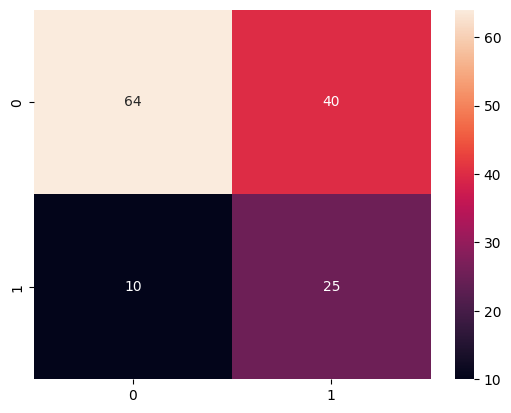

In [18]:
# Creating confusion matrix

cf = confusion_matrix(y_test, pred_)
sns.heatmap(cf, annot =True)